In [5]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import h3
import folium
import osmnx as ox
from shapely import wkt
from folium.plugins import HeatMap
from shapely.geometry import Polygon
import seaborn as sns
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'folium'

### Inputs

In [871]:
#set the hexagon size
#8 - sqm 0.74
#9 - sqm 0.10
#10 - sqm 0.015
h_size = 10
h_rings = 1
#Город
cities = ['Москва, Россия', 'Московская область, Россия', 'Санкт-Петербург, Россия']

### Hexagon visualisation function

In [872]:
#function fo hex visualization
def visualize_hexagons(hexagons, color="red", folium_map=None):

    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=20, tiles='cartodbpositron')
    else:
        m = folium_map
        
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m
h3_address = h3.geo_to_h3(55.73137191885491, 37.69820843895206,  h_size)                                                                                                   
visualize_hexagons(list(h3.k_ring(h3_address, h_rings)))

### Extract the data from OSM

In [881]:
#extract the data from OSM
def osm_query(tag, city):
    gdf = ox.geometries_from_place(city, tag).reset_index()
    gdf['city'] = np.full(len(gdf), city.split(',')[0])
    gdf['object'] = np.full(len(gdf), list(tag.keys())[0])
    gdf['type'] = np.full(len(gdf), tag[list(tag.keys())[0]])
    gdf = gdf[['city', 'object', 'type', 'geometry']]
    #print(gdf.shape)
    return gdf

# выводим центроиды полигонов
def get_lat_lon(geometry):
        
    lon = geometry.apply(lambda x: x.x if x.geom_type == 'Point' else x.centroid.x)
    lat = geometry.apply(lambda x: x.y if x.geom_type == 'Point' else x.centroid.y)
    return lat, lon
  
#Выгрузим интересующие нас категории объектов 
tags = [
        {'building' : 'dormitory'}, 
        {'building' : 'commercial'},
        {'building' : 'office'},
        {'building':'retail'},
        {'building':'kiosk'},
        {'highway' : 'bus_stop'},
        {'amenity':'cafe'}, {'amenity':'fast_food'}, {'amenity':'restaurant'}, {'amenity':'college'},
        {'amenity':'cinema'},  {'amenity':'school'}, {'amenity':'university'},  
        {'amenity':'bank'},  
        {'amenity':'pharmacy'}, {'amenity':'kindergarten'},
        {'railway':'subway_entrance'}, {'shop':'supermarket'}, 
        {'shop':'clothes'}, {'shop':'alcohol'}, {'shop':'mall'}, 
        {'shop':'shoes'}, {'shop':'electronics'}, {'shop':'furniture'}, {'shop':'florist'},
        {'shop':'jewelry'},  {'shop':'mobile_phone'},
        {'shop':'sports'}
       ]

gdfs = []
for city in cities:
    for tag in tags:
        gdfs.append(osm_query(tag, city))
        
# посмотрим что получилось
data_poi = pd.concat(gdfs)
data_poi.groupby(['city','object','type'], as_index = False).agg({'geometry':'count'})

# добавим координаты/центроиды
lat, lon = get_lat_lon(data_poi['geometry'])
data_poi['lat'] = lat
data_poi['lon'] = lon
data_poi.shape

(129425, 6)

In [882]:
data_poi['city'].value_counts()

Московская область    51298
Москва                51067
Санкт-Петербург       27060
Name: city, dtype: int64

In [886]:
data_poi['type'].value_counts()

bus_stop           31981
cafe                9252
supermarket         8575
retail              8305
pharmacy            7877
fast_food           7410
kindergarten        6066
clothes             5367
restaurant          4752
school              4427
alcohol             4332
bank                4106
office              3826
commercial          3824
florist             3489
mobile_phone        2769
kiosk               1937
mall                1571
furniture           1416
shoes               1396
subway_entrance     1291
electronics         1183
jewelry             1083
dormitory           1025
university           693
college              652
sports               524
cinema               296
Name: type, dtype: int64

### Process the data from OSM

In [884]:
#create a copy, to save the initial data
osm_data = data_poi.copy()
#Transform geo into h3 index
osm_data['hex'] = osm_data.apply(lambda row: h3.geo_to_h3(row['lat'], row['lon'], h_size), axis=1)

In [885]:
#create a new grouped types of objects
new_types = {'dormitory':'students_facilities', 'university':'students_facilities', 'college':'students_facilities',
             'hospital':'medical_facilities', 'clinic':'medical_facilities', 
             'cafe':'cafe & restaurants', 'restaurant':'cafe & restaurants', 'apartments':'residential_building', 
            'residential':'residential_building',
            'jewelry':'clothes & jewelry', 'shoes':'clothes & jewelry', 'clothes':'clothes & jewelry', 
            'electronics':'electronics', 'mobile_phone':'electronics'}

not_used_yet = {'furniture':'other_shops',  
    'hardware':'other_shops', 'beauty':'other_shops', 'doityourself':'other_shops',
    'variety_store':'other_shops', 'sports':'other_shops', 
                'department_store':'other_shops'}

osm_data.replace(new_types, inplace=True)
osm_data['type'].value_counts()

bus_stop               31981
cafe & restaurants     14004
supermarket             8575
retail                  8305
pharmacy                7877
clothes & jewelry       7846
fast_food               7410
kindergarten            6066
school                  4427
alcohol                 4332
bank                    4106
electronics             3952
office                  3826
commercial              3824
florist                 3489
students_facilities     2370
kiosk                   1937
mall                    1571
furniture               1416
subway_entrance         1291
sports                   524
cinema                   296
Name: type, dtype: int64

In [848]:
#calculate count of objects in each hex
osm_data_2 = (osm_data.groupby(['hex', 'type'])['object']
              .aggregate('count')
              .unstack()
              .reset_index())

In [849]:
osm_data_2.head(1)

type,hex,alcohol,bank,beauty,bus_stop,cafe & restaurants,cinema,clothes & jewelry,commercial,electronics,...,kiosk,mall,office,pharmacy,retail,school,sports,students_facilities,subway_entrance,supermarket
0,8a11060006b7fff,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Add shop details

In [833]:
folder_path = 'p:/FD-Supermarket/Отчетность/Игнатов/Geo-analytics/'
#geo coordinates of stores
df_st_coor = pd.read_excel(folder_path+'stores_geo.xlsx', header=0)
#sales by stores
df_st_sales = pd.read_excel(folder_path+'stores_sales.xlsx', header=0)

In [850]:
#Create hexagons around stores initial hex
df_st_coor['hex'] = df_st_coor.apply(lambda row: h3.geo_to_h3(row['lat'], row['lon'], h_size), axis=1)
df_st_coor['hex_area'] = df_st_coor.apply(lambda row: h3.k_ring(row['hex'], h_rings), axis=1)
df_st_coor.head(1)

,store,coordinates,lat,lon,hex,hex_area
0,E1008756,"58.01641688, 56.25871943",58.016417,56.258719,8a10f1ad0677fff,"{8a10f1ad062ffff, 8a10f1ad0747fff, 8a10f1ad060..."


In [851]:
#create a table that contains all generated hexagons for the store
st_hexagons = pd.DataFrame([])
for row in range(0, len(df_st_coor)):
    df = pd.DataFrame([])
    df['hex'] = list(df_st_coor['hex_area'][row])
    df['store'] = df_st_coor['store'][row]
    st_hexagons = pd.concat([st_hexagons, df], ignore_index=True)

In [852]:
st_hexagons.sample(1)

,hex,store
5865,8a11aa6a681ffff,E1010467


### Merge shop and OSM information

In [853]:
#add city objects to store table 
df_x = st_hexagons.merge(osm_data_2, how = 'left', on = 'hex')
df_x2 = df_x.groupby(['store']).sum(numeric_only=True)
#filter the count of apartments > 0 in order to drop stores from different area
df_x2 = df_x2.loc[~(df_x2==0).all(axis=1)]

In [854]:
#add sales by stores
df_x3 = df_x2.merge(df_st_sales, how='left', on='store')

<AxesSubplot:xlabel='sales'>

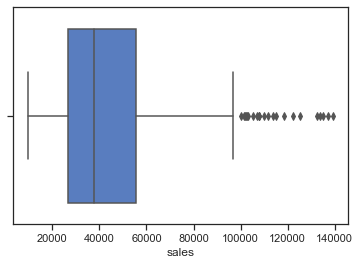

In [855]:
sns.boxplot(x=df_x3['sales'])

In [856]:
#Filter outlairs
df_x4 = df_x3
#df_x4 = df_x3.loc[(df_x3['sales']<100000) & (df_x3['sales']>15000)]

### Feature tranformation

In [857]:
#Get dummy variables
columns = ['cinema', 'subway_entrance']
for c in columns:
    df_x4[c] = df_x4.apply(lambda row: 1 if row[c] >= 1 else 0, axis=1)
#Log function to transform the data
#df_x4['sales'] = df_x4['sales'].apply(np.log1p)

In [858]:
c = df_x4.select_dtypes(include = ['float64', 'int64'])
c = c.corr()['sales'].sort_values(ascending=False)
c

sales                  1.000000
offline sales          0.994623
X_sqm                  0.672566
electronics            0.279763
fast_food              0.258761
subway_entrance        0.223774
X_Рыбный цех           0.221396
bus_stop               0.215639
bank                   0.211268
pharmacy               0.204092
clothes & jewelry      0.200479
X_Пекарня              0.190098
florist                0.181243
cafe & restaurants     0.160698
sports                 0.159420
cinema                 0.118540
kiosk                  0.113105
beauty                 0.100160
X_ТЦ                   0.089973
kindergarten           0.077295
X_Лицензия алко        0.061854
school                 0.055535
mall                   0.053745
X_Мясной цех           0.047801
furniture              0.046864
commercial             0.039769
office                -0.013469
retail                -0.017033
supermarket           -0.046977
alcohol               -0.047952
students_facilities   -0.080869
Name: sa

In [ ]:
#Drop useless features
df_x5 = df_x4.drop(['yes', 'retail', 'convenience', 'commercial', 'mall', 'doityourself', 'variety_store'
                   'hardware', 'beauty', 'department_store', 'furniture', 'atm', 'sports'], axis='columns') 

In [735]:
df_x4.corr(numeric_only=True).style.background_gradient(cmap='RdYlGn')

,alcohol,atm,bank,beauty,bus_stop,cafe & restaurants,cinema,clothes & jewelry,commercial,department_store,doityourself,electronics,fast_food,furniture,hardware,kindergarten,mall,office,other_shops,retail,school,sports,students_facilities,subway_entrance,supermarket,variety_store,sales,sqm,offline sales,ТЦ,Мясной цех,Рыбный цех,Пекарня,Лицензия алко
alcohol,1.000000,0.049349,0.102655,0.220669,0.064412,0.135891,-0.055916,0.024813,0.032941,0.211109,0.156820,0.023782,0.119833,-0.023433,0.115852,0.022645,0.013537,0.025893,0.357719,0.064426,-0.042937,-0.026115,0.007166,-0.012245,0.191574,0.084376,-0.044514,-0.095931,-0.038384,0.027965,-0.031278,-0.078086,0.074686,0.024058
atm,0.049349,1.000000,0.493967,0.246342,0.279389,0.442216,0.213365,0.351545,0.049735,0.109835,0.010760,0.601670,0.509756,0.173656,0.139793,-0.119146,0.382346,0.194481,0.455082,0.182487,0.005529,0.246723,0.041056,0.406997,0.077214,0.135043,0.125107,0.191893,0.142789,0.272392,-0.089262,-0.012500,-0.045772,-0.073075
bank,0.102655,0.493967,1.000000,0.335357,0.269237,0.479830,0.145690,0.248852,0.081272,0.160227,-0.022375,0.460813,0.332110,0.065535,0.068976,-0.031911,0.231753,0.212904,0.449744,0.075234,0.061838,0.138579,0.068705,0.425882,0.093580,0.091868,0.150704,0.095548,0.160149,0.240605,0.046445,0.077288,0.004565,0.044907
beauty,0.220669,0.246342,0.335357,1.000000,0.087227,0.400531,0.106302,0.244429,0.187884,0.093458,0.079967,0.230571,0.236184,0.045818,0.083921,0.002691,0.042058,0.235135,0.346715,0.067649,0.012164,0.127245,0.129820,0.135827,0.058275,0.121068,0.064438,0.016161,0.070845,0.037504,-0.003701,0.016214,0.024471,0.087817
bus_stop,0.064412,0.279389,0.269237,0.087227,1.000000,0.224307,0.090352,0.165912,-0.016039,0.025431,-0.066709,0.339857,0.282349,0.064202,0.076715,-0.052240,0.275639,0.044225,0.396972,0.066429,-0.046099,0.071521,0.037715,0.442633,0.072401,0.100245,0.177937,0.088008,0.196395,0.093954,0.039806,0.054764,0.005500,-0.067265
cafe & restaurants,0.135891,0.442216,0.479830,0.400531,0.224307,1.000000,0.284310,0.567606,0.141277,0.194390,0.001992,0.488898,0.612343,0.135194,0.066821,-0.098767,0.236634,0.302686,0.426480,0.125917,0.019324,0.314478,0.170337,0.371712,0.039732,0.063135,0.205826,0.157820,0.223867,0.240461,-0.015178,0.038538,0.007817,-0.018617
cinema,-0.055916,0.213365,0.145690,0.106302,0.090352,0.284310,1.000000,0.351031,0.084290,-0.036646,-0.066310,0.452774,0.383574,0.160682,0.156344,-0.108044,0.324252,-0.026745,0.033638,0.024663,-0.021885,0.372368,-0.078450,0.190483,0.008535,0.066421,0.143205,0.188609,0.160279,0.276622,-0.066058,0.043450,-0.019813,-0.028780
clothes & jewelry,0.024813,0.351545,0.248852,0.244429,0.165912,0.567606,0.351031,1.000000,0.041977,0.133944,-0.006532,0.523570,0.650057,0.157797,0.064105,-0.097542,0.261982,0.053466,0.295732,0.083473,-0.023382,0.466489,-0.022875,0.194944,-0.053756,0.080853,0.207650,0.222274,0.229447,0.247366,-0.048771,0.003508,0.007791,-0.031292
commercial,0.032941,0.049735,0.081272,0.187884,-0.016039,0.141277,0.084290,0.041977,1.000000,0.051952,-0.027366,0.065246,0.047597,0.056284,-0.009889,-0.025394,0.059314,0.165352,0.053297,0.168888,-0.026290,0.029098,0.028432,0.026549,-0.027197,0.062450,0.038717,-0.007649,0.042615,0.099309,0.032614,-0.021937,0.001565,0.069088
department_store,0.211109,0.109835,0.160227,0.093458,0.025431,0.194390,-0.036646,0.133944,0.051952,1.000000,0.055499,0.106677,0.202078,0.011504,0.057126,-0.001192,0.015275,0.114682,0.192948,0.045685,-0.017605,0.026684,-0.002857,0.117176,0.099386,0.045660,0.034498,-0.011297,0.044404,0.155167,-0.001423,-0.018404,0.007801,0.000571


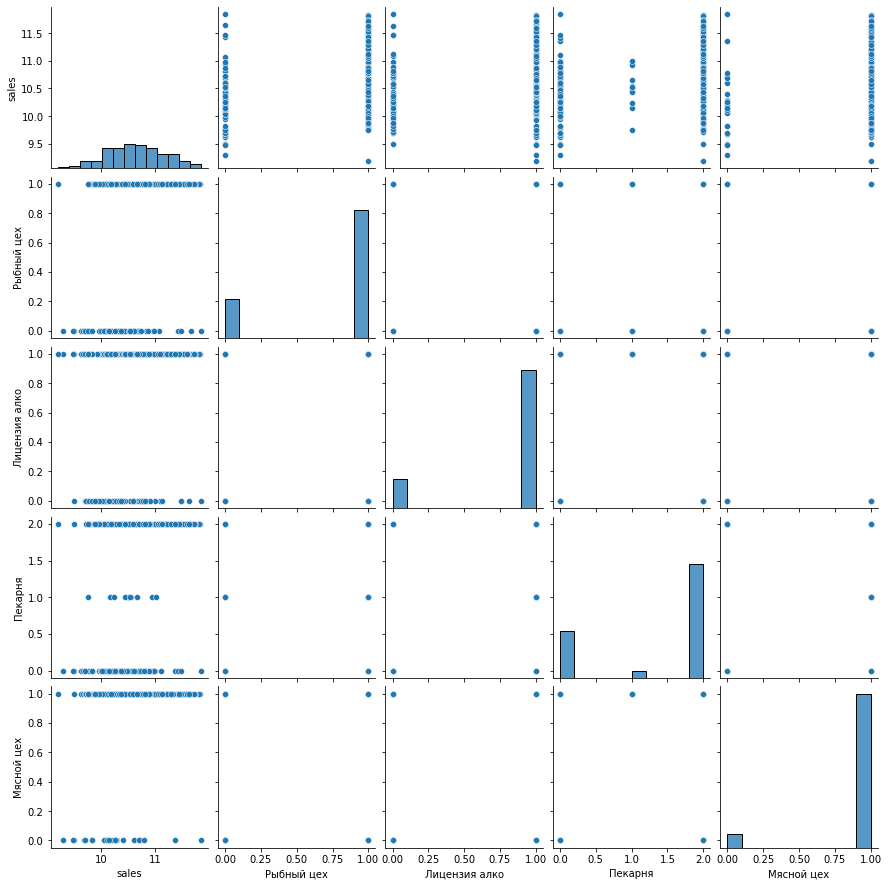

In [493]:
sns.pairplot(df_x5[['sales', 'Рыбный цех', 'Лицензия алко', 'Пекарня', 'Мясной цех']])
plt.show()

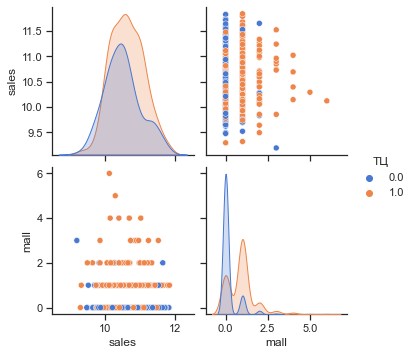

In [605]:
sns.set_theme(style='ticks', palette='muted')
sns.pairplot(df_x4[['sales', 'ТЦ', 'mall']], hue="ТЦ", palette='muted')

In [859]:
#d = pd.DataFrame(c)
d['v2'] = c
d

,sales,v2
sales,1.000000,1.000000
offline sales,0.994624,0.994623
X_sqm,0.672339,0.672566
fast_food,0.275762,0.258761
electronics,0.269115,0.279763
X_Рыбный цех,0.222670,0.221396
subway_entrance,0.219009,0.223774
clothes & jewelry,0.207650,0.200479
cafe & restaurants,0.205826,0.160698
pharmacy,0.192522,0.204092


In [ ]:
folder_path = 'p:/FD-Supermarket/Отчетность/Игнатов/Geo-analytics/'
osm_data.to_excel(folder_path+ 'osm_data.xlsx', index=False) #Сохранение в excel

In [211]:
data_poi.head()

,city,object,type,geometry,lat,lon
0,Москва,building,apartments,POINT (37.57809 55.65122),55.651221,37.578088
1,Москва,building,apartments,POINT (37.56970 55.65271),55.652710,37.569699
2,Москва,building,apartments,"POLYGON ((37.42680 55.84512, 37.42677 55.84523...",55.845690,37.426733
3,Москва,building,apartments,"POLYGON ((37.42645 55.84645, 37.42641 55.84656...",55.847007,37.426367
4,Москва,building,apartments,"POLYGON ((37.42409 55.84758, 37.42427 55.84758...",55.847457,37.424205


In [ ]:
#Convert unit format to float
one_hot_encode_cols = (df_x4.
                       dtypes[df_x4.dtypes == np.uint8]
                       .index
                       .tolist())  # filtering columns unit types
for col in one_hot_encode_cols: 
    df_x4[col] = df_x4[col].apply(np.float64)